In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('mps')

In [33]:
num_epochs = 10
batch_size = 4
learning_rate = 0.001

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [28]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

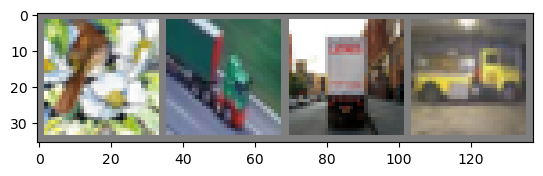

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

In [29]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)

In [30]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 6000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/20], Step [6000/12500], Loss: 2.2886
Epoch [1/20], Step [12000/12500], Loss: 1.8784
Epoch [2/20], Step [6000/12500], Loss: 2.3424
Epoch [2/20], Step [12000/12500], Loss: 1.4407
Epoch [3/20], Step [6000/12500], Loss: 1.5057
Epoch [3/20], Step [12000/12500], Loss: 2.2107
Epoch [4/20], Step [6000/12500], Loss: 1.0933
Epoch [4/20], Step [12000/12500], Loss: 1.3338
Epoch [5/20], Step [6000/12500], Loss: 1.5008
Epoch [5/20], Step [12000/12500], Loss: 1.7228
Epoch [6/20], Step [6000/12500], Loss: 1.3374
Epoch [6/20], Step [12000/12500], Loss: 2.3129
Epoch [7/20], Step [6000/12500], Loss: 1.8429
Epoch [7/20], Step [12000/12500], Loss: 1.8712
Epoch [8/20], Step [6000/12500], Loss: 0.4452
Epoch [8/20], Step [12000/12500], Loss: 1.5025
Epoch [9/20], Step [6000/12500], Loss: 0.6625
Epoch [9/20], Step [12000/12500], Loss: 0.7380
Epoch [10/20], Step [6000/12500], Loss: 1.6895
Epoch [10/20], Step [12000/12500], Loss: 0.9769
Epoch [11/20], Step [6000/12500], Loss: 1.0698
Epoch [11/20], Step [

In [31]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [32]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred: n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 63.3 %
Accuracy of plane: 71.5 %
Accuracy of car: 73.5 %
Accuracy of bird: 64.1 %
Accuracy of cat: 49.1 %
Accuracy of deer: 58.7 %
Accuracy of dog: 40.2 %
Accuracy of frog: 65.5 %
Accuracy of horse: 68.3 %
Accuracy of ship: 78.8 %
Accuracy of truck: 63.3 %
